# Analysis Notebook
This notebook contains methods and code for performing visual analysis on the extracted pageviews data on the academy award winning movies. It uses files from the `data_final` folder. This notebook will produce three different graphs. 1. Maximum Average and Minimum Average 2. Top 10 Peak Page Views 3. Fewest Months of Data

In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
pd.options.mode.chained_assignment = None  # default='warn'

The first step is to load in our extracted data from the `data_final` folder. These files are the output from running the `data_aquisition.ipynb` notebook. We can load these in easily using the json package and store them as python dictionaries.

In [3]:
# Loading in the three json files
with open('../data_final/academy_monthly_mobile_201507-202309.json', 'r') as f:
    mobile_dict = json.load(f)
with open('../data_final/academy_monthly_desktop_201507-202309.json', 'r') as f:
    desktop_dict = json.load(f)
with open('../data_final/academy_monthly_cumulative_201507-202309.json', 'r') as f:
    cumulative_dict = json.load(f)

Now that we have loaded in the data, we want to reformat them in a format that makes it easier to analyze. I have chosen to use Pandas Dataframes, because they work well for time series data. Below I have written a function that takes in a dictionary of the movie data and returns out a Pandas Dataframe. In this function I also make sure to convert the timestamp column to a datetime object so we can work with the correct data type.

In [37]:
# reformatting the data
def reformat_dict_as_df(data_dict):
    """
    Convert a dictionary of movie data into a pandas DataFrame.

    Parameters:
    -----------
    data_dict : dict
        A dictionary containing movie data. Each key represents a movie name,
        and each corresponding value is a list of dictionaries with monthly views data.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with columns including 'timestamp' converted to datetime format,
        representing the timestamp of each monthly view, and other columns with
        specific data for each monthly view.
    """
    final_data = []
    for movie in data_dict.values():
        for monthly_views in movie:
            final_data.append(monthly_views)
    df = pd.DataFrame(final_data)
    # Converting to proper timestamp format
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d%S")
    return df

After writing the function, converting the dictionaries is as easy as calling the function on each of them and saving them into new variables. We now have our pandas dictionaries.

In [38]:
# Reformatting the dictionaries into dataframes
mobile_df = reformat_dict_as_df(mobile_dict)
desktop_df = reformat_dict_as_df(desktop_dict)
cumulative_df = reformat_dict_as_df(cumulative_dict)

#### 1. Maximum Average and Minimum Average

The first visualization that we want to generate is a time series plot of the monthly view data for the movies that had the highest average and lowest average monthly views. We want this for both Mobile and Desktop access types. To reduce redundant code, I have written a function to find these movies. This method works by grouping the dataframes by `article` (the movie name) and computing a aggregate statistic, `mean` in this case across each movie. We can then, sort these results by the average monthly views and take the first and last movie in this list. We will use these two names to perform further filtering later.

In [68]:
def find_highest_lowest_monthly(df):
    """
    Find the articles with the highest and lowest average monthly views from a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing monthly views data for different articles. It should have at least two columns:
        'article' (article names) and a numeric column representing the monthly views.

    Returns:
    --------
    tuple
        A tuple containing two strings:
        - The article name with the highest average monthly views.
        - The article name with the lowest average monthly views.
    """
    avg_df = df.groupby('article').agg('mean', numeric_only=True).reset_index()
    avg_df.columns = ['article', 'average monthly views']
    avg_df.sort_values('average monthly views', ascending=False, inplace=True)
    return avg_df.iloc[0, 0], avg_df.iloc[-1, 0]

Below, I am calling my `find_highest_lowest_monthly` method to extract the maximum and minimum monthly view movie titles. In the next step I filter the original mobile and desktop dataframes by the article name.

In [77]:
# Retrieving Maximum Average and Minimum Average for mobile and desktop
mobile_high_low = find_highest_lowest_monthly(mobile_df)
desktop_high_low = find_highest_lowest_monthly(desktop_df)

# Extracting monthly data
mobile_max_avg = mobile_df[mobile_df['article'] == mobile_high_low[0]]
mobile_min_avg = mobile_df[mobile_df['article'] == mobile_high_low[1]]
desktop_max_avg = desktop_df[desktop_df['article'] == desktop_high_low[0]]
desktop_min_avg = desktop_df[desktop_df['article'] == desktop_high_low[1]]

Now that we have four dataframes, we want to combine to plot. However, to dilineate between the values, it would be nice to have a legend. We can do this by creating an additional Legend column on each of these columns before we concatenate them together.

In [199]:
# Creating labels to delineate between access types and maximum and minimum averages
mobile_max_avg.loc[:, 'Legend'] = f'Max Mobile: {mobile_high_low[0]}'
mobile_min_avg.loc[:, 'Legend'] = f'Min Mobile: {mobile_high_low[1]}'
desktop_max_avg.loc[:, 'Legend'] = f'Max Desktop: {desktop_high_low[0]}'
desktop_min_avg.loc[:, 'Legend'] = f'Min Desktop: {desktop_high_low[1]}'

concat_df = pd.concat([desktop_max_avg, desktop_min_avg, mobile_max_avg, mobile_min_avg]).reset_index()

The final step is plotting. We can use seaborn's lineplot to quickly plot the result! We also save the result as a png into the results folder.

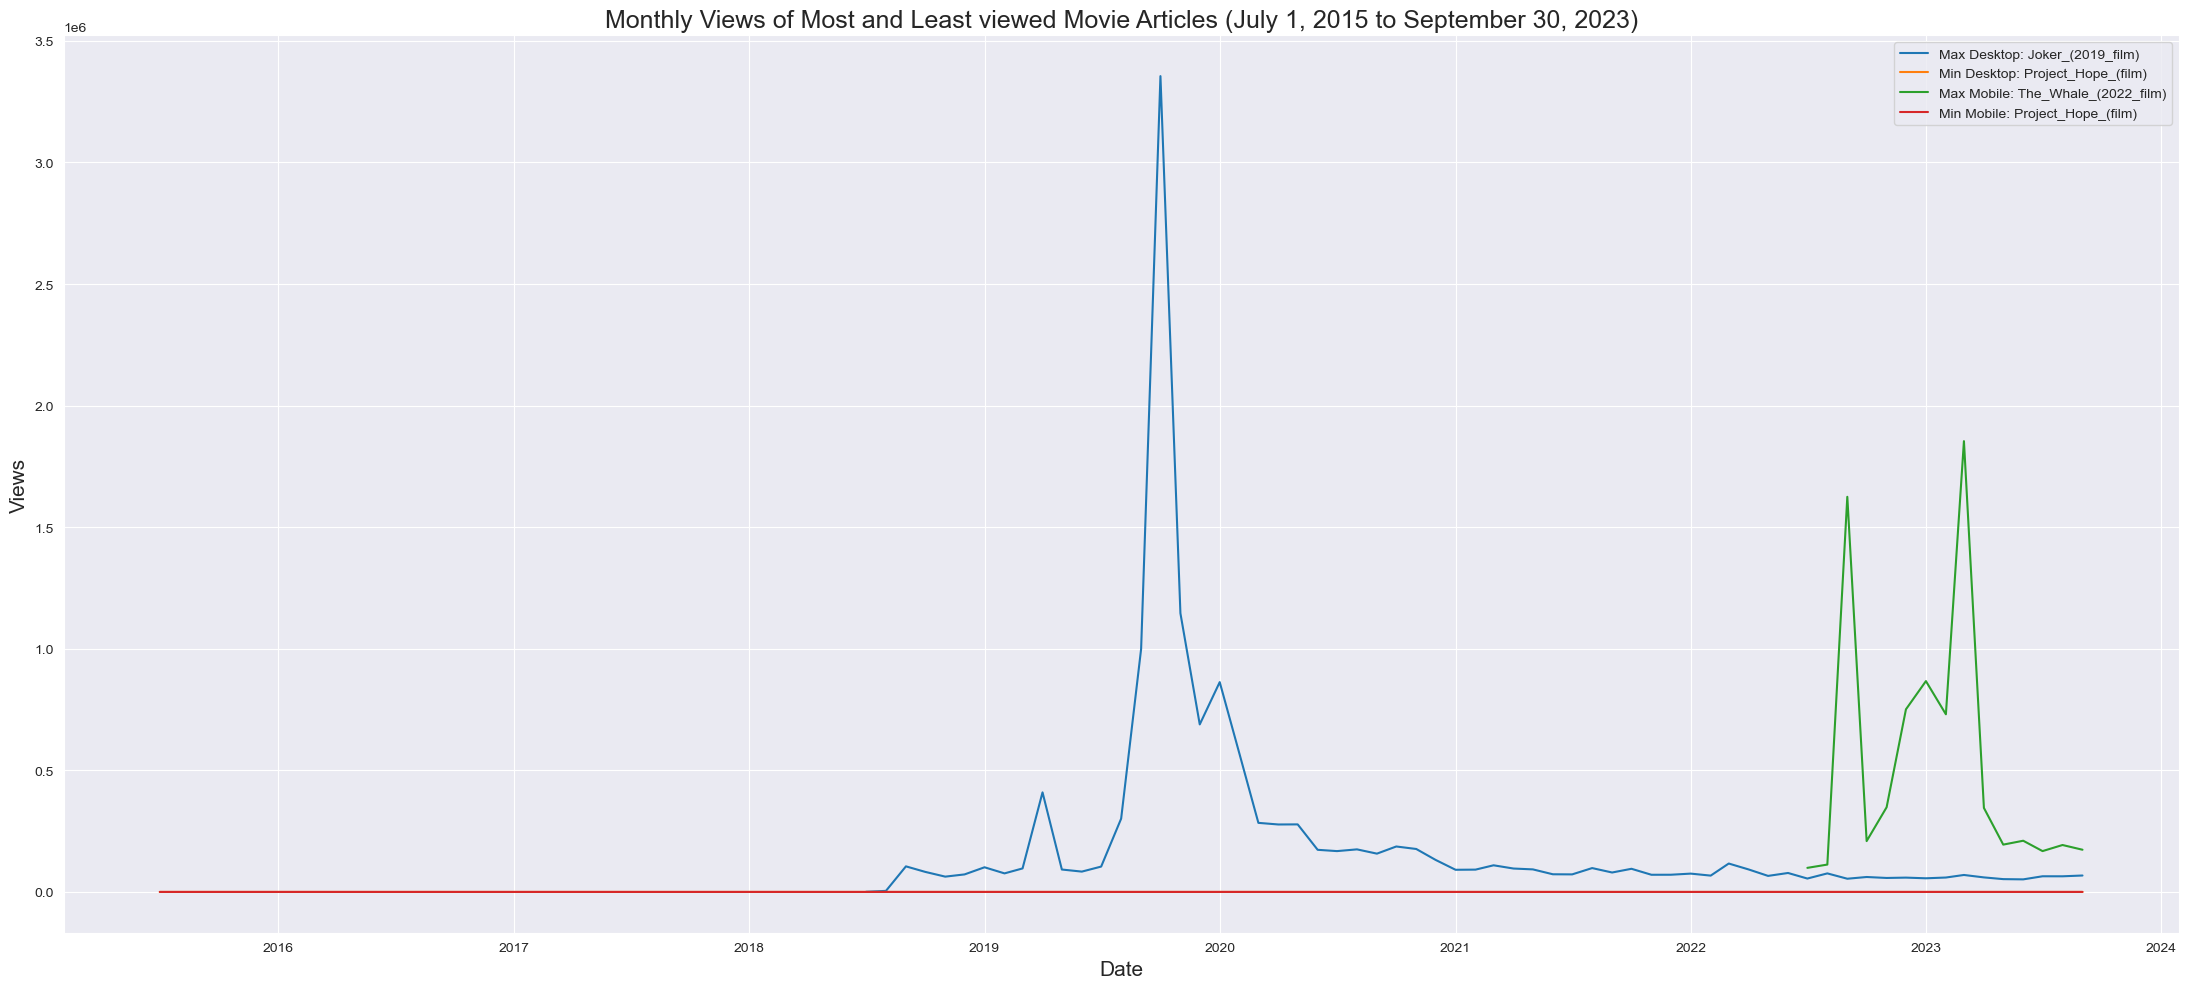

In [204]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.lineplot(data=concat_df, x='timestamp', y='views', hue='Legend', ax=ax)
sns.move_legend(ax, "upper left")
plt.title('Maximum and Minimum Average views')
plt.title('Monthly Views of Most and Least viewed Movie Articles (July 1, 2015 to September 30, 2023)', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Views', fontsize=15)
plt.legend(title='')
plt.tight_layout()
plt.savefig('../results/Plot_1_Max_Min_Avg.png')

#### 2. Top 10 Peak Page Views

The second visualization that we want to create is a times series plot of the top 10 movies with the highest peaks for each access type. The first step in this process is to find the movies of interest. Since we are interested in peaks now instead of averages, we can write a similar method as before, but now use `max` in our aggregation function. Now, since we actually want the top 10 movies instead of just the first and last, we can use pandas `.iloc` method to slice and extract the movie titles.

In [151]:
def find_top_ten_peaks_monthly(df):
    """
    Find the top ten articles with the highest peak monthly views from a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing monthly views data for different articles. It should have at least two columns:
        'article' (article names) and a numeric column representing the monthly views.

    Returns:
    --------
    list
        A list containing the names of the top ten articles with the highest peak monthly views.
    """
    avg_df = df.groupby('article').agg('max', numeric_only=True).reset_index()
    avg_df.columns = ['article', 'average monthly views']
    avg_df.sort_values('average monthly views', ascending=False, inplace=True)
    return list(avg_df.iloc[0:10, 0])

Similar to the steps in the first visualization, we call our filter function, filter the original dataframes, create a legend column, and concatenate the new dataframes. Finally, we can plot the time series data with seaborn again.

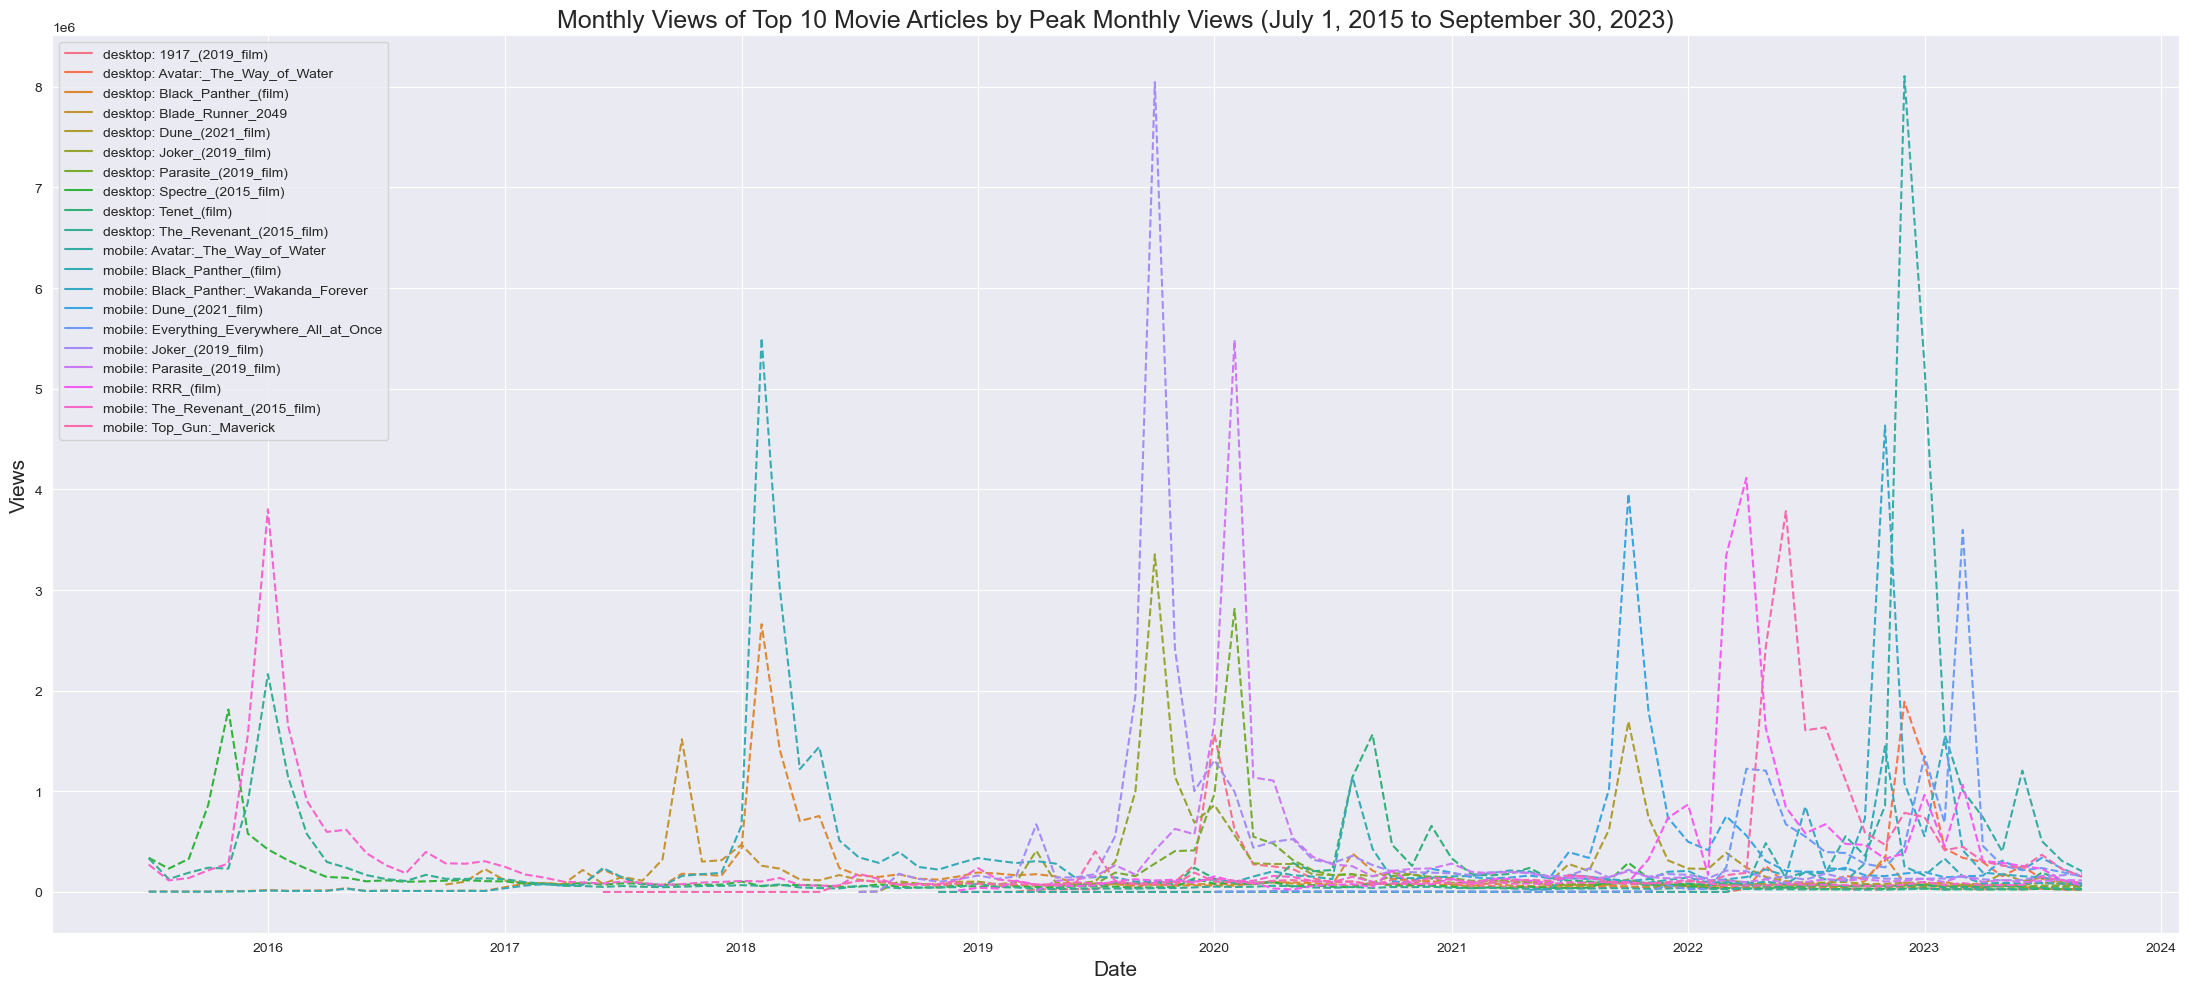

In [205]:
mobile_top_peaks = find_top_ten_peaks_monthly(mobile_df)
desktop_top_peaks = find_top_ten_peaks_monthly(desktop_df)

# Filtering for only the top peaks
mobile_peaks = mobile_df[mobile_df['article'].isin(mobile_top_peaks)]
desktop_peaks = desktop_df[desktop_df['article'].isin(desktop_top_peaks)]

# Creating a legend column
mobile_peaks['legend'] = 'mobile: ' + mobile_peaks['article']
desktop_peaks['legend'] = 'desktop: ' + desktop_peaks['article']
combined_peaks = pd.concat([desktop_peaks, mobile_peaks]).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(22, 10))
sns.lineplot(data=combined_peaks, x='timestamp', y='views', hue='legend', ax=ax, linestyle='dashed')
sns.move_legend(ax, "upper left")
plt.title('Monthly Views of Top 10 Movie Articles by Peak Monthly Views (July 1, 2015 to September 30, 2023)', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Views', fontsize=15)
plt.legend(title='')
plt.tight_layout()
plt.savefig('../results/Plot_2_Top_10_Peaks.png')

In [ ]:
plt.savefig('../results/')

#### 3. Fewest Months of Data

For our last visualization we want to find the movies with the least amount of monthly page view data. In other words we are looking for the most recent Academy Awards winning movies. Similar to the previous visualization we want to get the 10 most recent. Below I write a very similar function to above, except now we use `count` as the aggregate method. This works because if there is no data on a movie, ie that movie hasn't come out yet, then it won't be in the dataframe. After we sort the dataframe in an ascending manner, we can slice for the first 10 movies.

In [190]:
def find_ten_most_recent_movies(df):
    """
    Find the names of the ten most recently added Academy Award winning movies in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing monthly views of movie data. It should have the column
        'article' (article names).

    Returns:
    --------
    list
        A list containing the names of the ten most recently added movies.
    """
    avg_df = df.groupby('article').agg('count').reset_index()
    avg_df.sort_values('views', ascending=True, inplace=True)
    return list(avg_df.iloc[0:10, 0])

Applying our function, we call the function on both the mobile and desktop dataframes and store the resulting lists. Then, using these lists we filter the original mobile and desktop dataframes. Again, we generate our legend column, concatenate the dataframes, and finally plot our time series data.

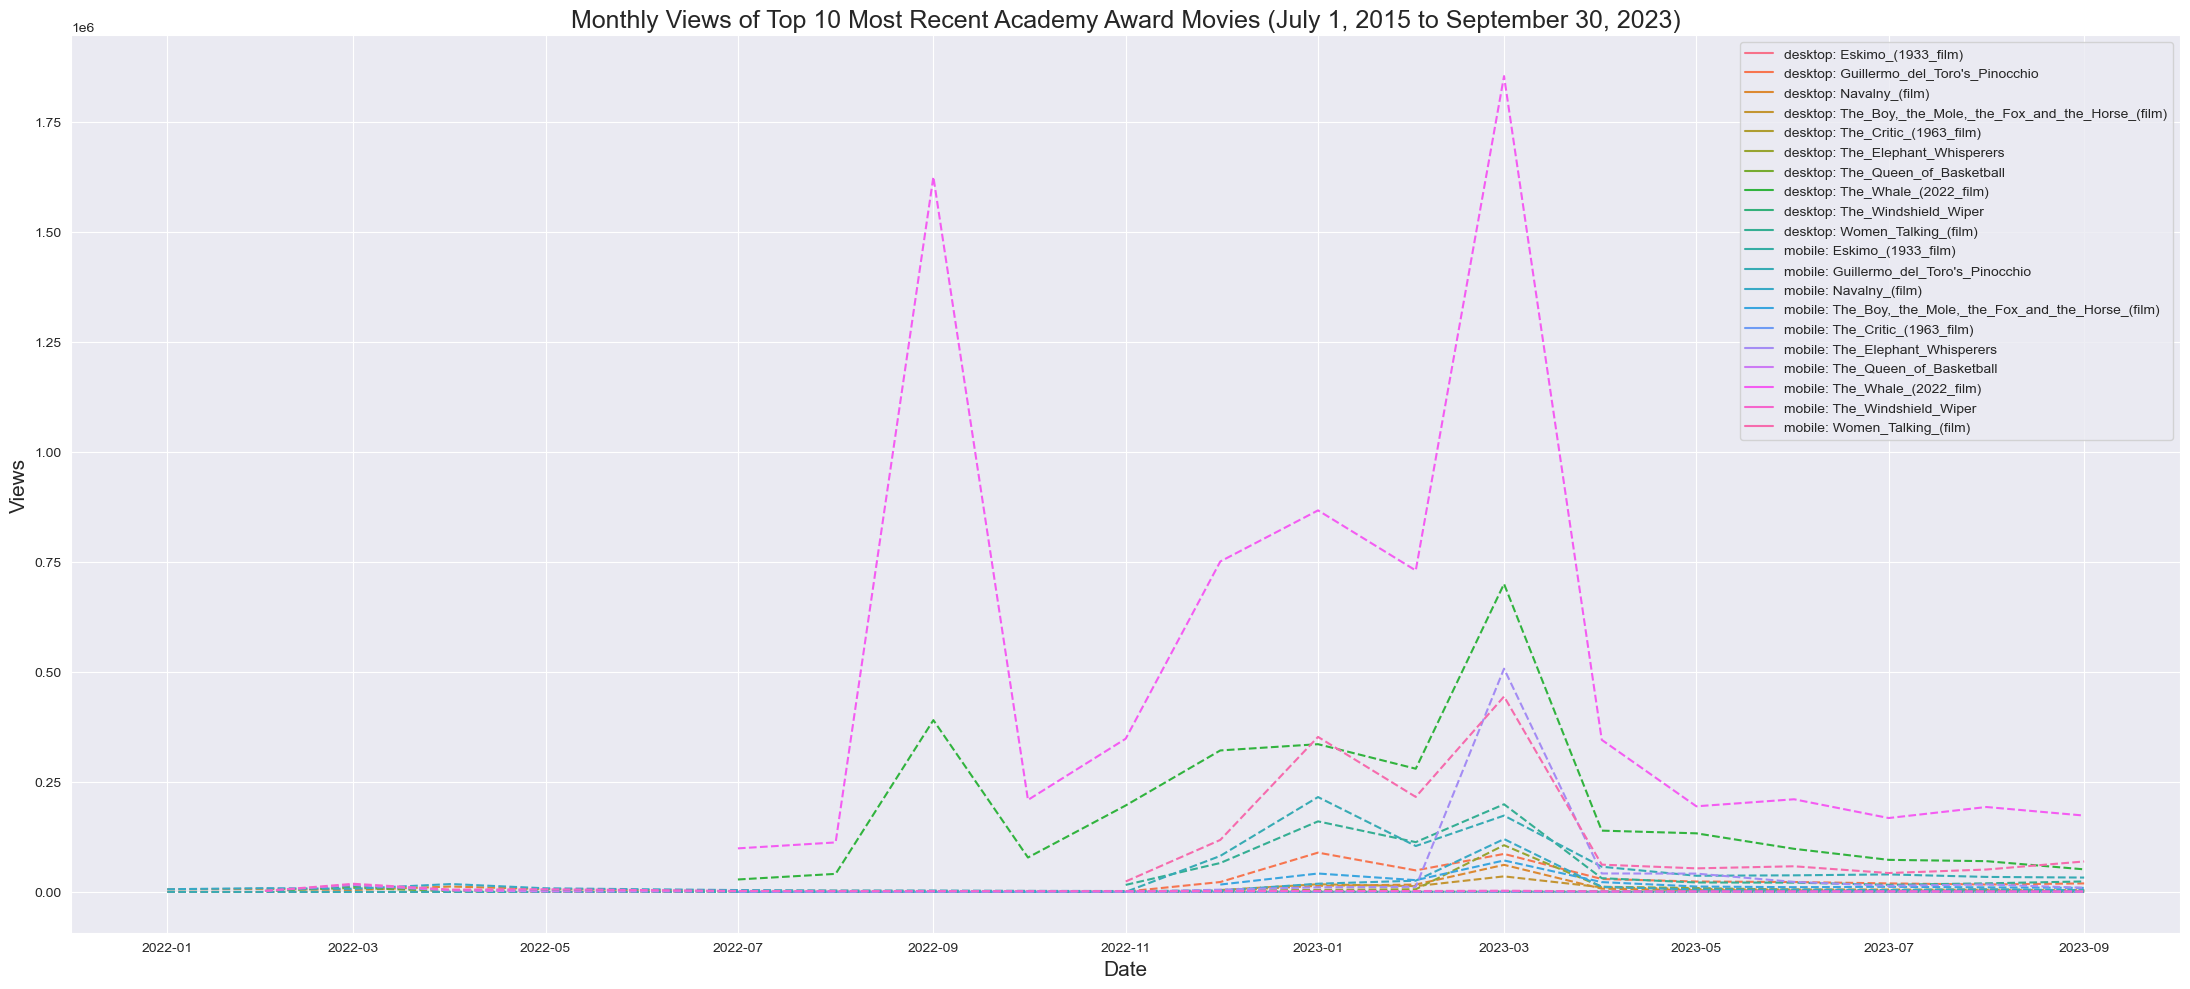

In [206]:
# Retrieving movie titles of the ten most recent movies by Access type
mobile_recent = find_ten_most_recent_movies(mobile_df)
desktop_recent = find_ten_most_recent_movies(desktop_df)

# Filtering for only the top peaks
mobile_recent_df = mobile_df[mobile_df['article'].isin(mobile_recent)]
desktop_recent_df = desktop_df[desktop_df['article'].isin(desktop_recent)]

# Creating a legend column
mobile_recent_df['legend'] = 'mobile: ' + mobile_recent_df['article']
desktop_recent_df['legend'] = 'desktop: ' + desktop_recent_df['article']
combined_peaks = pd.concat([desktop_recent_df, mobile_recent_df]).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(22, 10))
sns.lineplot(data=combined_peaks, x='timestamp', y='views', hue='legend', ax=ax, linestyle='dashed')
sns.move_legend(ax, "upper left")
plt.title('Monthly Views of Top 10 Most Recent Academy Award Movies (July 1, 2015 to September 30, 2023)', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Views', fontsize=15)
plt.legend(title='')
plt.tight_layout()
plt.savefig('../results/Plot_3_Top_10_Most_Recent.png')